In [1]:
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
import keras
import numpy as np
import cv2
from tensorflow.keras.utils import plot_model
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, MaxPool2D
from keras.models import Model


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Data Sets

In [2]:
train_path = '/kaggle/input/chest-xray-images-pneumonia-with-new-class/Data_blance/Train'
test_path = '/kaggle/input/chest-xray-images-pneumonia-with-new-class/Data_blance/Test'
val_path = '/kaggle/input/chest-xray-images-pneumonia-with-new-class/Data_blance/Val'

In [3]:
batch_size = 64
image_size = 224

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    shuffle = True,
    image_size=(image_size,image_size),
    batch_size = batch_size
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle = True,
    image_size=(image_size,image_size),
    batch_size = batch_size
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    shuffle = True,
    image_size=(image_size,image_size),
    batch_size = batch_size
)
class_names=train_dataset.class_names


Found 3900 files belonging to 3 classes.
Found 300 files belonging to 3 classes.
Found 279 files belonging to 3 classes.


# Explor data 

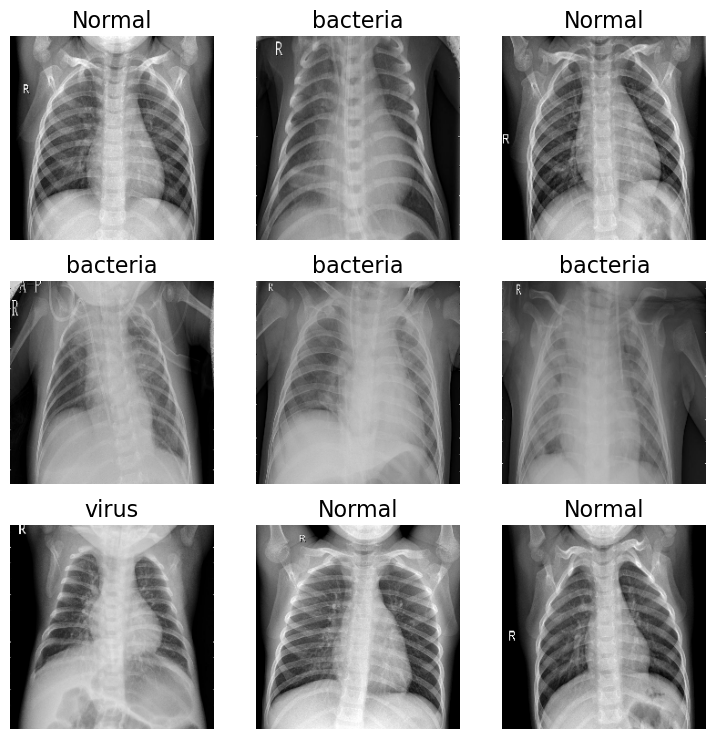

In [4]:
plt.figure(figsize=(9,9))
for image_batch , label_batch in train_dataset.take(1):
  for i in range(9):#9=3*3
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]],fontsize=16)
    plt.axis('off')

# Models

# Pretrained VGG

In [6]:
tf.keras.backend.clear_session()
vgg_model = VGG16(weights = "imagenet", include_top=False,# Notice that this downloaded architecture does not contain the classifier part (three fully connected layers) at the top of the network because we set the include_top argument to False.
 input_shape = (224,224, 3))

In [7]:
for layer in vgg_model.layers:
  layer.trainable = False

In [8]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
last_layer = vgg_model.get_layer('block5_pool')

x=MaxPool2D()(last_layer.output)
x = Flatten()(x)
x=Dense(128 , activation='relu')(x)
x=Dense(64 , activation='relu')(x)
x=Dense(32 , activation='relu')(x)
x=Dense(16 , activation='relu')(x)
x=Dense(3 , activation='softmax')(x)

vgg_model = Model(inputs=vgg_model.input, outputs=x)
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
vgg_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

### Train the model on the data 
### Accuracy = 97%

In [12]:
his = vgg_model.fit(
    train_dataset,
 epochs = 2,
 batch_size = 32,
 validation_data = val_dataset
)

Epoch 1/2
61/61 [==============================] - 34s 529ms/step - loss: 0.6795 - accuracy: 0.7426 - val_loss: 0.5320 - val_accuracy: 0.7742
Epoch 2/2
61/61 [==============================] - 19s 278ms/step - loss: 0.4507 - accuracy: 0.8118 - val_loss: 0.5386 - val_accuracy: 0.7849


### Save VGG model in h5 file

In [13]:
model = vgg_model

# Save the model to an h5 file
model.save('my_vgg_model.h5')

# Test Model

In [14]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = vgg_model.predict(img_array)
  predictions_class = class_names[np.argmax(predictions[0])]
  conf = round(100*(np.max(predictions[0])),2)
  return predictions_class , conf

1/1 [==============================] - 0s 20ms/step


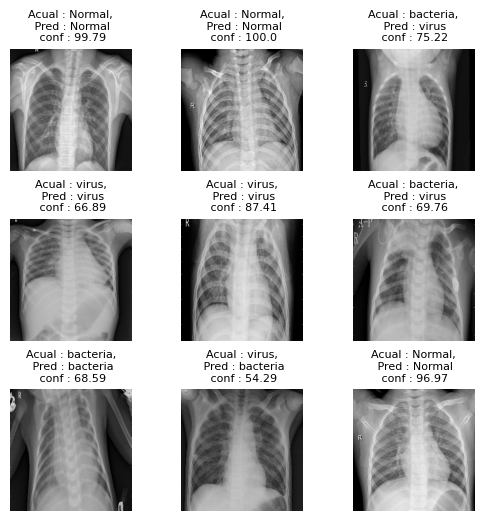

In [15]:
plt.figure(figsize=(6,6))
for images , labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    pred,conf = predict(vgg_model,images[i].numpy())
    acu_cl = class_names[labels[i]]

    plt.title(f"Acual : {acu_cl},\n Pred : {pred}\n conf : {conf}",fontsize=8)
    plt.axis('off')

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.show()

# 

# 

# Pretrained densenet

In [16]:
densnet_model = tf.keras.applications.DenseNet201(weights = "imagenet", include_top=False,# Notice that this downloaded architecture does not contain the classifier part (three fully connected layers) at the top of the network because we set the include_top argument to False.
 input_shape = (224,224, 3))


74836368/74836368 [==============================] - 0s 0us/step


In [17]:
for layer in densnet_model.layers:
  layer.trainable = False

In [18]:
last_layer = densnet_model.get_layer('conv5_block16_concat')

x=MaxPool2D()(last_layer.output)
x = Flatten()(x)
x=Dense(128 , activation='relu')(x)
x=Dense(64 , activation='relu')(x)
x=Dense(32 , activation='relu')(x)
x=Dense(16 , activation='relu')(x)
x=Dense(3 , activation='softmax')(x)

densnet_model = Model(inputs=densnet_model.input, outputs=x)
densnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [19]:
densnet_model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

### Train the model on the data 
### Accuracy = 88%

In [21]:
his = densnet_model.fit(
    train_dataset,
    epochs=1,
    validation_data=val_dataset
)

61/61 [==============================] - 20s 288ms/step - loss: 0.4713 - accuracy: 0.7995 - val_loss: 0.4592 - val_accuracy: 0.7849


### Save Densnet model in h5 file

In [22]:
model = densnet_model

# Save the model to an h5 file
model.save('my_densnet_model.h5')

# Test Densnet model

In [23]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array,0)

  predictions = densnet_model.predict(img_array)
  predictions_class = class_names[np.argmax(predictions[0])]
  conf = round(100*(np.max(predictions[0])),2)
  return predictions_class , conf

1/1 [==============================] - 0s 34ms/step


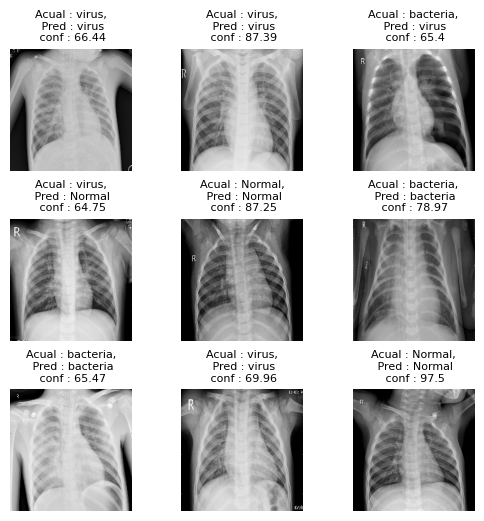

In [24]:
plt.figure(figsize=(6,6))
for images , labels in test_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    pred,conf = predict(densnet_model,images[i].numpy())
    acu_cl = class_names[labels[i]]

    plt.title(f"Acual : {acu_cl},\n Pred : {pred}\n conf : {conf}",fontsize=8)
    plt.axis('off')

plt.subplots_adjust(wspace=0.4, hspace=0.4)

plt.show()